<a href="https://colab.research.google.com/github/Mohammadhsiavash/DeepL-Training/blob/main/Computer%20Vision/Satellite_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision matplotlib segmentation-models-pytorch numpy Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 6.4 MB/s eta 0:00:00


Creating 10 dummy images and masks...
Dummy data creation complete.


/tmp/ipython-input-2310710479.py:64: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(image_np, 'RGB')
/tmp/ipython-input-2310710479.py:65: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask = Image.fromarray(mask_np, 'L') # 'L' mode for single channel grayscale
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Using device: cuda

Starting model training...
Epoch [1/10], Loss: 2.0565
Epoch [2/10], Loss: 1.5077
Epoch [3/10], Loss: 1.1566
Epoch [4/10], Loss: 0.8906
Epoch [5/10], Loss: 0.7143
Epoch [6/10], Loss: 0.5866
Epoch [7/10], Loss: 0.4905
Epoch [8/10], Loss: 0.4005
Epoch [9/10], Loss: 0.3329
Epoch [10/10], Loss: 0.2786
Training finished.
Visualizing a sample prediction...


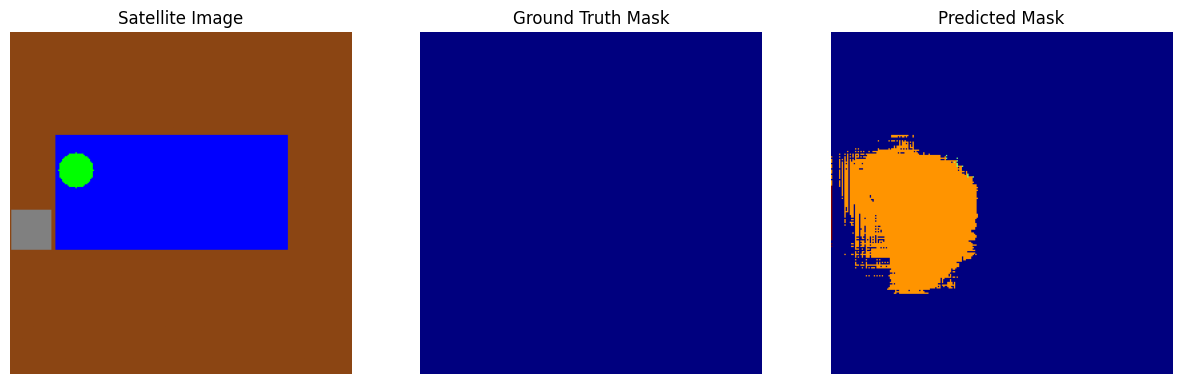

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

## Step 1: Simulate Satellite Dataset
# In a real-world scenario, you would download a dataset like DeepGlobe.
# For this example, we'll create a dummy dataset programmatically.

def create_dummy_data(img_dir="data/images", mask_dir="data/masks", num_samples=10, img_size=(256, 256)):
    """Generates and saves simple RGB images and corresponding segmentation masks."""
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(mask_dir, exist_ok=True)

    # Define color mappings for classes
    # Class 0: Background (brown)
    # Class 1: Water (blue)
    # Class 2: Vegetation (green)
    # Class 3: Building (gray)
    # Class 4: Road (dark gray)
    class_colors = {
        0: (139, 69, 19),   # Brown
        1: (0, 0, 255),     # Blue
        2: (0, 255, 0),     # Green
        3: (128, 128, 128), # Gray
        4: (105, 105, 105)  # Dark Gray
    }

    print(f"Creating {num_samples} dummy images and masks...")
    for i in range(num_samples):
        # Create a background image and a mask
        image_np = np.full((*img_size, 3), class_colors[0], dtype=np.uint8)
        mask_np = np.zeros(img_size, dtype=np.uint8)

        # Add a "water" body (rectangle)
        x1, y1 = np.random.randint(0, img_size[0]//2, 2)
        x2, y2 = np.random.randint(img_size[0]//2, img_size[0], 2)
        image_np[y1:y2, x1:x2] = class_colors[1]
        mask_np[y1:y2, x1:x2] = 1

        # Add a "vegetation" patch (circle)
        cx, cy = np.random.randint(0, img_size[0], 2)
        radius = np.random.randint(10, 40)
        Y, X = np.ogrid[:img_size[0], :img_size[1]]
        dist_from_center = np.sqrt((X - cx)**2 + (Y-cy)**2)
        image_np[dist_from_center <= radius] = class_colors[2]
        mask_np[dist_from_center <= radius] = 2

        # Add a "building" (smaller rectangle)
        bx1, by1 = np.random.randint(0, img_size[0] - 30, 2)
        image_np[by1:by1+30, bx1:bx1+30] = class_colors[3]
        mask_np[by1:by1+30, bx1:bx1+30] = 3

        # Convert numpy arrays to PIL Images
        img = Image.fromarray(image_np, 'RGB')
        mask = Image.fromarray(mask_np, 'L') # 'L' mode for single channel grayscale

        # Save images
        img.save(os.path.join(img_dir, f"sample_{i}.png"))
        mask.save(os.path.join(mask_dir, f"sample_{i}.png"))

    print("Dummy data creation complete.")


## Step 2: Create a Custom PyTorch Dataset
class SatelliteDataset(Dataset):
    """
    Custom Dataset for loading satellite images and their corresponding masks.
    """
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        # Get a sorted list of image filenames
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.masks[idx])

        # Open image and mask
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") # Ensure mask is single channel

        # Apply transformations if any
        if self.transform:
            img = self.transform(img)

        # The mask also needs to be transformed into a tensor.
        # We don't apply other augmentations to the mask, just resize and convert to tensor.
        mask_transform = T.Compose([
            T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
            T.ToTensor()
        ])
        mask = mask_transform(mask)
        # Convert mask to Long type and remove channel dimension (C, H, W) -> (H, W)
        mask = mask.squeeze(0).long()

        return img, mask

## Step 3: Define Model, Loss, and Training Loop

def main():
    # --- Configuration ---
    IMAGE_DIR = "data/images"
    MASK_DIR = "data/masks"
    BATCH_SIZE = 4
    NUM_CLASSES = 5 # 0:background, 1:water, 2:veg, 3:building, 4:road
    EPOCHS = 10
    LEARNING_RATE = 0.001

    # --- 1. Data Preparation ---
    create_dummy_data(img_dir=IMAGE_DIR, mask_dir=MASK_DIR)

    # Define transformations for the input images
    transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Create dataset and dataloader
    train_ds = SatelliteDataset(IMAGE_DIR, MASK_DIR, transform=transform)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)

    # --- 2. Model Definition ---
    # Use segmentation_models_pytorch library for a pre-trained UNet
    model = smp.Unet(
        encoder_name='resnet18',        # Choose encoder, e.g., 'resnet34'
        encoder_weights='imagenet',     # Use 'imagenet' pre-trained weights
        in_channels=3,                  # Model input channels (3 for RGB)
        classes=NUM_CLASSES,            # Model output channels (number of classes)
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    print(f"Using device: {device}")

    # --- 3. Training Setup ---
    # Loss function for multi-class segmentation
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # --- 4. Training Loop ---
    print("\nStarting model training...")
    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss/len(train_loader):.4f}")
    print("Training finished.")

    # --- 5. Visualize Predictions ---
    print("Visualizing a sample prediction...")
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        # Get a single batch
        sample_img, sample_mask = next(iter(train_loader))
        sample_img, sample_mask = sample_img.to(device), sample_mask.to(device)

        # Make prediction
        pred_logits = model(sample_img)
        # Convert logits to prediction map (taking argmax along the class dimension)
        pred_mask = torch.argmax(pred_logits, dim=1)

        # Move tensors to CPU for plotting
        sample_img_cpu = sample_img.cpu()
        sample_mask_cpu = sample_mask.cpu()
        pred_mask_cpu = pred_mask.cpu()

        # Denormalize image for visualization
        inv_normalize = T.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
        img_to_show = inv_normalize(sample_img_cpu[0])

        # Plot the results
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(img_to_show.permute(1, 2, 0))
        plt.title("Satellite Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(sample_mask_cpu[0], cmap='jet', vmin=0, vmax=NUM_CLASSES-1)
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask_cpu[0], cmap='jet', vmin=0, vmax=NUM_CLASSES-1)
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.show()

if __name__ == '__main__':
    main()